disini saya karena memakai Google Collab Saya membuaka Gdrive saya sendiri lalu dari gdrive tersebut mengambil data yang telah di split untuk di lakukan training pada data tersebut

data sekaran memiliki struktur seperti ini

DataSplitTrain/Train/suku/img.jpg

DataSplitTrain/val/suku/img.jpg

DataSplitTrain/test/suku/img.jpg

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!cp /content/drive/MyDrive/PCD/DataSplitTrain.zip

!unzip -q /content/drive/MyDrive/PCD/DataSplitTrain.zip

Check ketersedian GPU

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Setting Training dan juga setting Data yang akan di gunakan

In [ ]:
# Setting nya di sini aja
size = 280 # besar gambar yang nanti menjadi input layer
IMG_SIZE = (size, size)
BATCH_SIZE = 32 # berapa data per training
Epochs = 50 #pengulangan berapa kali di training

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)


#Data Yang dipakai untuk Training(Di Augmentasi kan)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



train_generator = train_datagen.flow_from_directory(
    '/content/DataSplitTrain/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    '/content/DataSplitTrain/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    '/content/DataSplitTrain/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # penting untuk evaluasi
)


#Check Jumalah class Yang ada

num_classes = len(train_generator.class_indices)
print("Train classes:", train_generator.class_indices)
print("Val classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 305 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Found 72 images belonging to 3 classes.
Train classes: {'Jawa': 0, 'Minang': 1, 'Sunda': 2}
Val classes: {'Jawa': 0, 'Minang': 1, 'Sunda': 2}
Test classes: {'Jawa': 0, 'Minang': 1, 'Sunda': 2}


Disini Saya Fine-Tuning Dengan Model MobileNetV2 hal ini dikarenakan ResNet Memiliki model yang terlalu besar yang menyebabkan Overfitting terlalu cepat jadi hasil nya lebih baik menggunakan MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2 # Ambil Pre-Trained Model MovileNetV2
# from tensorflow.keras.applications import ResNet50 # Ambil Pre-Trained Model ResNet50 kalau mau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load pre-trained ResNet50
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

# Add classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-4-7184baaf33c5>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 280, 280,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 140, 140,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 140, 140,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 140, 140,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 140, 140,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 140, 140,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 140, 140,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 140, 140,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 140, 140,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 140, 140,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 140, 140,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 140, 140,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 141, 141,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 70, 70,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 70, 70,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 70, 70,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 70, 70,    │      2,304 │ block_1_depthwis

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stop = EarlyStopping(
    monitor='val_loss',         # Bisa diganti ke 'val_accuracy' sesuai kebutuhan
    patience=5,                 # Berhenti jika val_loss tidak membaik 5 epoch berturut-turut
    restore_best_weights=True  # Kembalikan model ke bobot terbaik
)


lr_reduce = ReduceLROnPlateau(
    monitoring = 'val_loss',
    factor=0.5,
    patience=2,
    verbose=1
    )


checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/PCD/best_model.keras", # model terbaik disimpan di Drive
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=val_generator,
    callbacks=[early_stop,lr_reduce, checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3931 - loss: 1.3358
Epoch 1: val_loss improved from inf to 1.17740, saving model to /content/drive/MyDrive/PCD/best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4000 - loss: 1.3232 - val_accuracy: 0.3750 - val_loss: 1.1774 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.6863 - loss: 0.7913
Epoch 2: val_loss did not improve from 1.17740
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.6856 - loss: 0.7905 - val_accuracy: 0.3750 - val_loss: 1.1999 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.7791 - loss: 0.5739
Epoch 3: val_loss improved from 1.17740 to 1.13698, saving model to /content/drive/MyDrive/PCD/best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 784ms/step - accuracy: 0.7781 - loss: 0.5729 - val_accuracy: 0.4375 - val_loss: 1.1370 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - acc

In [ ]:
model.save(str(size)+"_"+str(Epochs)+ "_Trained_model_etnisIndo.keras") # save Model Terbaik

Nah disini dapat Dilihat data Evaluasi yang di hasilkan oleh model seperti
- akurasi
- confidence Score per kelas
- Confusion Matrix
- ROC-AUC (One vs Rest)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
✅ Accuracy: 0.6667

📋 Classification Report (Precision, Recall, F1 per kelas):
              precision    recall  f1-score   support

        Jawa       0.59      0.67      0.63        24
      Minang       0.64      0.70      0.67        23
       Sunda       0.80      0.64      0.71        25

    accuracy                           0.67        72
   macro avg       0.68      0.67      0.67        72
weighted avg       0.68      0.67      0.67        72



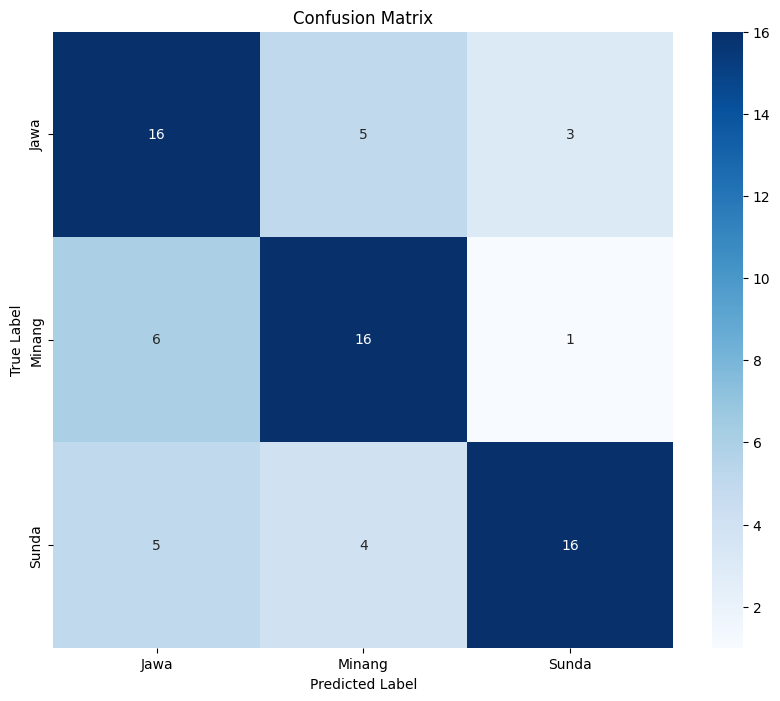

🎯 ROC-AUC Score (macro avg): 0.8330


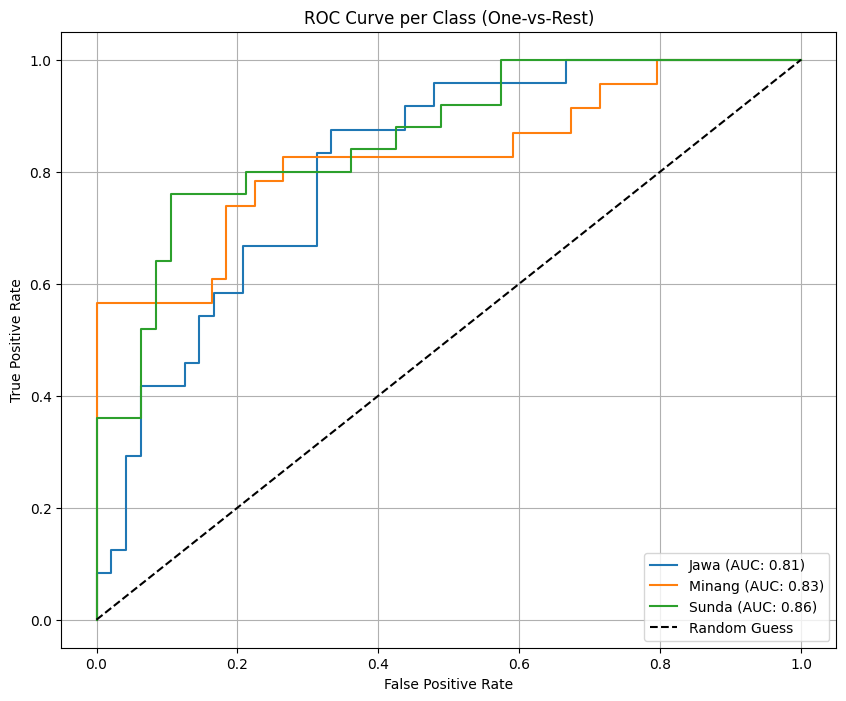

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# ====== Prediksi data test ======
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
n_classes = len(class_labels)

# ========== 1. Accuracy ==========
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

# ========== 2. Classification Report ==========
print("\n📋 Classification Report (Precision, Recall, F1 per kelas):")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ========== 3. Confusion Matrix ==========
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ========== 4. ROC-AUC (One-vs-Rest) ==========
# Binarize label
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Macro average ROC-AUC
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
print(f"🎯 ROC-AUC Score (macro avg): {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC: {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


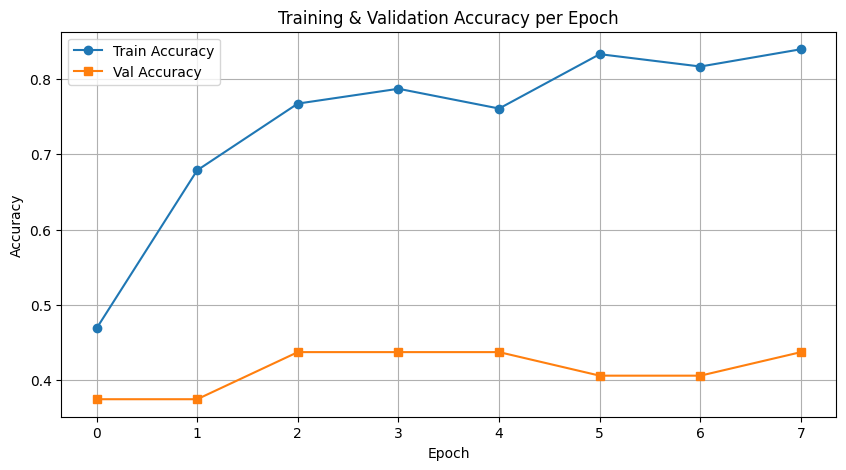

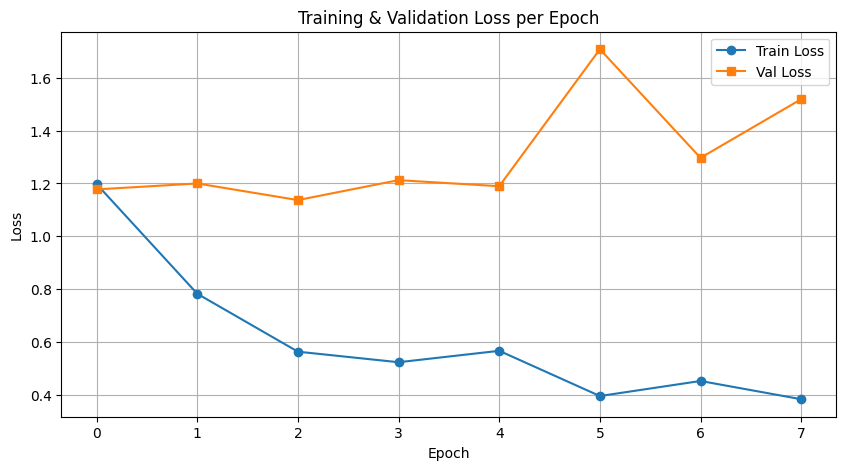

In [ ]:
# ====== Visualisasi Training Performance ======
import matplotlib.pyplot as plt

# Akurasi
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Training & Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
